In [ ]:
  from google.colab import drive 
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Robotics project I/Codes

## Import packages

In [ ]:
! pip install albumentations==0.4.6

In [ ]:
!pip install thop

In [ ]:
!pip install pytorch-gradcam

In [ ]:
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import albumentations as A
from sklearn.metrics import ConfusionMatrixDisplay
import torch
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

from albumentations.pytorch import ToTensorV2
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch.optim import lr_scheduler
import torchvision.transforms as transforms

cudnn.benchmark = True

from implementations import *
from utils import *
from data_augmentation import *

## Data augmentation

In [ ]:
base_folder = '/content/drive/MyDrive/Robotics project I/'
sys.path.append(base_folder)
patches_file = base_folder + 'Datasets/dataset_patches.npz'
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                  A.Rotate (limit=45, interpolation=1, border_mode=4, p=1), 
                  A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=1),
                  A.Resize(224, 224)
                  ])  
# Augment_red_factor, augment whole data factor, testset_ratio, val_ratio
#data_augmentation(patches_file, trsf, base_folder, 0, 0.10, 0.18)

## Models

In [ ]:
base_folder = '/content/drive/MyDrive/Robotics project I/'

model_names = {0:'model_scratch', 1:'model_pretrained', 2:'model_frangi', 3:'model_frangi_reversed', 4:'model_simsiam', 5:'model_simsiam_frangi', 6:'model_art_data'}
import os
if not os.path.exists(base_folder+'Results'):
      os.makedirs(base_folder+'Results')

if not os.path.exists(base_folder+'Models'):
      os.makedirs(base_folder+'Models')

if not os.path.exists(base_folder+'CV_Results'):
      os.makedirs(base_folder+'CV_Results')

if not os.path.exists(base_folder+'CV_Results_frangi'):
      os.makedirs(base_folder+'CV_Results_frangi')

## Initialize dataloader & set parameters 

In [ ]:
### Define network parameters
base_folder = '/content/drive/MyDrive/Robotics project I/'
sys.path.append(base_folder)
modelName = 'resnet18'
mini_batch_size = 20
num_epochs = 25
num_classes = 2
class_names = [0, 1]
class_names = ['Culprit', 'Non culprit']
lr = 0.0015

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Set paths to access data
train_file = base_folder + 'Datasets/training_patches_augRed.npz'
val_file = base_folder + 'Datasets/validation_patches_augRed.npz'
test_file = base_folder + 'Datasets/test_patches.npz'
model_folder = base_folder + '/Results/'

# Change the augmentation probabilities for rotate and shift scale rotate
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                  A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                  A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                  A.Resize(224, 224)
                  ]) 

### Initialize data loader
data_train = CardioDataset(train_file, trsf, to_tensor = True)
data_val = CardioDataset(val_file, trsf, to_tensor = True)
dataloader = []
dataloader = {'train': DataLoader(data_train,  mini_batch_size, shuffle=True, num_workers=0), 'val': DataLoader(data_val,  mini_batch_size, shuffle=True, num_workers=0)}
dataset_sizes = {'train': len(data_train), 'val': len(data_val)}

## Train model pretrained on artificial data

True
Epoch 0/24
----------
train Loss: 0.8453 Acc: 0.5340
val Loss: 0.7013 Acc: 0.6121
Sensitivity:  0.45  Specificity:  0.77  F1 score:  0.54

Epoch 1/24
----------
train Loss: 0.7213 Acc: 0.6075
val Loss: 0.7976 Acc: 0.6000
Sensitivity:  0.35  Specificity:  0.84  F1 score:  0.47

Epoch 2/24
----------
train Loss: 0.6698 Acc: 0.6582
val Loss: 0.9203 Acc: 0.6000
Sensitivity:  0.98  Specificity:  0.23  F1 score:  0.71

Epoch 3/24
----------
train Loss: 0.6948 Acc: 0.6422
val Loss: 0.7563 Acc: 0.5455
Sensitivity:  0.27  Specificity:  0.82  F1 score:  0.37

Epoch 4/24
----------
train Loss: 0.6077 Acc: 0.6849
val Loss: 0.7953 Acc: 0.5939
Sensitivity:  0.57  Specificity:  0.61  F1 score:  0.58

Epoch 5/24
----------
train Loss: 0.6445 Acc: 0.6822
val Loss: 0.6500 Acc: 0.6424
Sensitivity:  0.59  Specificity:  0.70  F1 score:  0.62

Epoch 6/24
----------
train Loss: 0.5769 Acc: 0.7210
val Loss: 0.6425 Acc: 0.6788
Sensitivity:  0.70  Specificity:  0.66  F1 score:  0.68

Epoch 7/24
----------


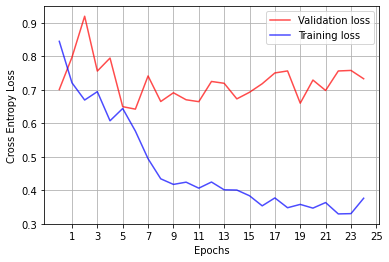

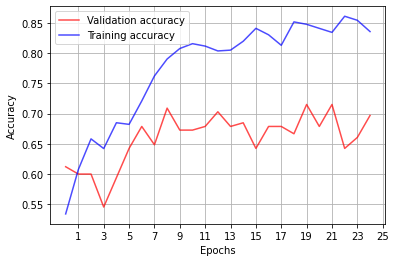

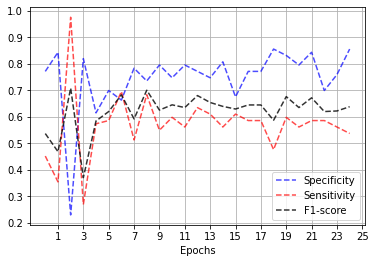

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

model_art_data = initialize_model(modelName, num_classes, pretrained_model=False).to(device)
# Load weights pretrained on artificial data 
state_dict = torch.load(base_folder+'Artificial data model/ep20', map_location=lambda storage, loc: storage)
new_state_dict = model_art_data.state_dict()

for k, v in state_dict.items():
    if k[:6] == 'model.':
        name = k[6:]  # remove `model.`
        if name == 'fc.weight':
          name = 'fc.1.weight'
        elif name == 'fc.bias':
          name = 'fc.1.bias'
    else:
        name = k
    new_state_dict[name] = v

# Training
model_art_data.load_state_dict(new_state_dict)

scratch_optimizer = optim.SGD(model_art_data.parameters(), lr=lr, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(scratch_optimizer, step_size=7, gamma=0.1)

scratch_criterion = nn.CrossEntropyLoss()

model_art_data, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val = train_model_v3(model_art_data, dataloader,dataset_sizes, scratch_criterion, scratch_optimizer, exp_lr_scheduler,
                       num_epochs)

# Save performance plots and model
plot_performance(base_folder,model_names[6],num_epochs, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val, save=False)
#torch.save(model_art_data.state_dict(), base_folder+'Models/'+model_names[6]+'.pth')

## Learn a model from scratch 

True
Epoch 0/24
----------
train Loss: 0.7497 Acc: 0.5287
val Loss: 0.6740 Acc: 0.5636
Sensitivity:  0.93  Specificity:  0.20  F1 score:  0.68

Epoch 1/24
----------
train Loss: 0.7823 Acc: 0.5194
val Loss: 0.7281 Acc: 0.4909
Sensitivity:  0.13  Specificity:  0.84  F1 score:  0.21

Epoch 2/24
----------
train Loss: 0.7869 Acc: 0.5314
val Loss: 0.9793 Acc: 0.5030
Sensitivity:  1.00  Specificity:  0.01  F1 score:  0.67

Epoch 3/24
----------
train Loss: 0.7577 Acc: 0.5274
val Loss: 0.7321 Acc: 0.5212
Sensitivity:  0.32  Specificity:  0.72  F1 score:  0.40

Epoch 4/24
----------
train Loss: 0.7215 Acc: 0.5407
val Loss: 0.7469 Acc: 0.5333
Sensitivity:  0.89  Specificity:  0.18  F1 score:  0.65

Epoch 5/24
----------
train Loss: 0.7331 Acc: 0.5621
val Loss: 0.7021 Acc: 0.5273
Sensitivity:  0.09  Specificity:  0.96  F1 score:  0.15

Epoch 6/24
----------
train Loss: 0.7147 Acc: 0.5674
val Loss: 0.7077 Acc: 0.5879
Sensitivity:  0.74  Specificity:  0.43  F1 score:  0.64

Epoch 7/24
----------


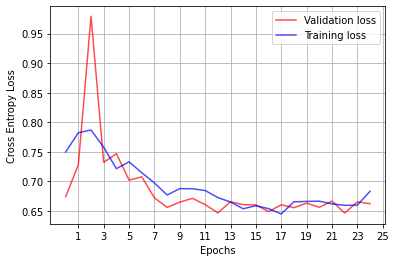

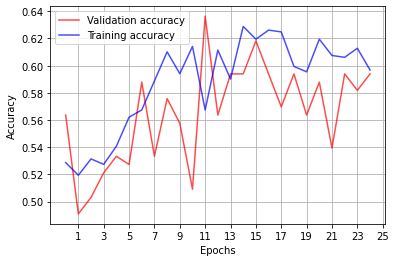

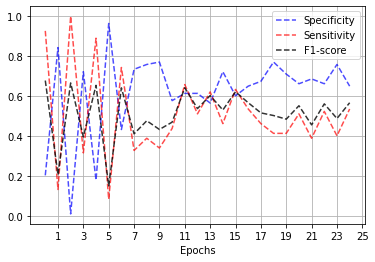

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Initialize the non-pretrained version of the model used for this run0
scratch_model = initialize_model(modelName, num_classes, pretrained_model=False).to(device)

scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=lr, weight_decay=0.0227, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(scratch_optimizer, step_size=7, gamma=0.1)

scratch_criterion = nn.CrossEntropyLoss()

scratch_model, scratch_hist, scratch_hist_train, scratch_specificity, scratch_sensitivity, scratch_f1_score, scratch_loss_train, scratch_loss_val = train_model_v3(scratch_model, dataloader,dataset_sizes, scratch_criterion, scratch_optimizer, exp_lr_scheduler,
                       num_epochs)

# Save performance plots and model
plot_performance(base_folder,model_names[0],num_epochs, scratch_hist, scratch_hist_train, scratch_specificity, scratch_sensitivity, scratch_f1_score, scratch_loss_train, scratch_loss_val, save=False)
#torch.save(scratch_model.state_dict(), base_folder+'Models/'+model_names[0]+'.pth')

## Model pretrained from ImageNet 

True
Epoch 0/24
----------
train Loss: 0.7905 Acc: 0.5461
val Loss: 0.6476 Acc: 0.5939
Sensitivity:  0.49  Specificity:  0.70  F1 score:  0.54

Epoch 1/24
----------
train Loss: 0.7205 Acc: 0.6115
val Loss: 0.7215 Acc: 0.5818
Sensitivity:  0.30  Specificity:  0.86  F1 score:  0.42

Epoch 2/24
----------
train Loss: 0.7217 Acc: 0.6328
val Loss: 0.7082 Acc: 0.6000
Sensitivity:  0.78  Specificity:  0.42  F1 score:  0.66

Epoch 3/24
----------
train Loss: 0.6823 Acc: 0.6368
val Loss: 0.7497 Acc: 0.5758
Sensitivity:  0.22  Specificity:  0.93  F1 score:  0.34

Epoch 4/24
----------
train Loss: 0.6476 Acc: 0.6716
val Loss: 0.6041 Acc: 0.7273
Sensitivity:  0.82  Specificity:  0.64  F1 score:  0.75

Epoch 5/24
----------
train Loss: 0.6226 Acc: 0.6809
val Loss: 0.6553 Acc: 0.6182
Sensitivity:  0.49  Specificity:  0.75  F1 score:  0.56

Epoch 6/24
----------
train Loss: 0.5578 Acc: 0.7330
val Loss: 0.6849 Acc: 0.6606
Sensitivity:  0.50  Specificity:  0.82  F1 score:  0.59

Epoch 7/24
----------


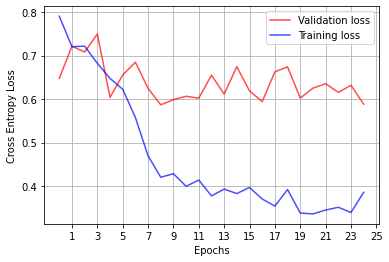

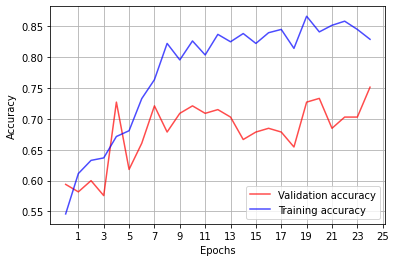

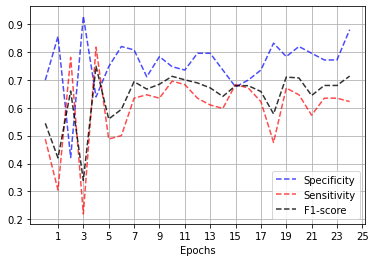

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

model_regular = initialize_model(modelName, num_classes, pretrained_model=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_regular.parameters(), lr=lr, weight_decay=0.0227, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_regular, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val = train_model_v3(model_regular, dataloader,dataset_sizes, criterion, optimizer, exp_lr_scheduler,
                       num_epochs)

# Save performance plots and model
plot_performance(base_folder,model_names[1],num_epochs, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val, save=False)
#torch.save(model_regular.state_dict(), base_folder+'Models/'+model_names[1]+'.pth')

## Train model with frangi input

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



True
Epoch 0/24
----------
train Loss: 0.7756 Acc: 0.5674
val Loss: 0.6719 Acc: 0.5939
Sensitivity:  0.34  Specificity:  0.84  F1 score:  0.46

Epoch 1/24
----------
train Loss: 0.7731 Acc: 0.5728
val Loss: 0.6684 Acc: 0.6485
Sensitivity:  0.72  Specificity:  0.58  F1 score:  0.67

Epoch 2/24
----------
train Loss: 0.7396 Acc: 0.6088
val Loss: 0.7294 Acc: 0.5212
Sensitivity:  0.18  Specificity:  0.86  F1 score:  0.28

Epoch 3/24
----------
train Loss: 0.6761 Acc: 0.6168
val Loss: 0.6814 Acc: 0.5939
Sensitivity:  0.33  Specificity:  0.86  F1 score:  0.45

Epoch 4/24
----------
train Loss: 0.6344 Acc: 0.6422
val Loss: 0.8402 Acc: 0.5152
Sensitivity:  0.11  Specificity:  0.92  F1 score:  0.18

Epoch 5/24
----------
train Loss: 0.6282 Acc: 0.6622
val Loss: 0.7250 Acc: 0.5212
Sensitivity:  0.07  Specificity:  0.96  F1 score:  0.13

Epoch 6/24
----------
train Loss: 0.6086 Acc: 0.6555
val Loss: 0.6922 Acc: 0.5939
Sensitivity:  0.26  Specificity:  0.93  F1 score:  0.39

Epoch 7/24
----------

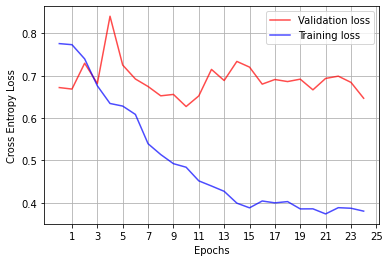

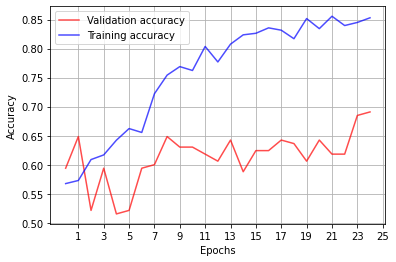

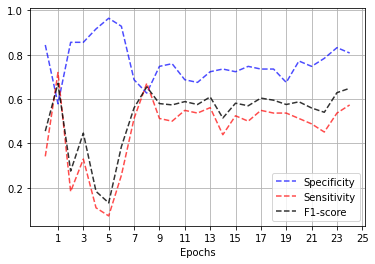

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
### Initialize data loader with CardioFrangi
data_train = CardioDatasetFrangi(train_file, trsf, to_tensor = True, reverse=False) 
data_val = CardioDatasetFrangi(val_file, trsf, to_tensor = True, reverse=False) 
dataloader = []
dataloader = {'train': DataLoader(data_train,  mini_batch_size, shuffle=True, num_workers=0), 'val': DataLoader(data_val,  mini_batch_size, shuffle=True, num_workers=0)}
dataset_sizes = {'train': len(data_train), 'val': len(data_val)}

model_frangi = initialize_model(modelName, num_classes, pretrained_model=True)

# Modify input channel from 3 to 4
model_frangi.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_frangi = model_frangi.to(device) 
criterion = nn.CrossEntropyLoss()
l_rate = 0.0025
w_decay_frangi = 0.1557 #5e-3
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_frangi.parameters(), lr=l_rate,weight_decay=w_decay_frangi, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_frangi, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val = train_model_Frg(model_frangi, dataloader, dataset_sizes,  criterion, optimizer, exp_lr_scheduler,
                      num_epochs)
plot_performance(base_folder,model_names[2],num_epochs, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val, save=False)
#torch.save(model_frangi.state_dict(), base_folder+'Models/'+model_names[2]+'.pth')

## Train model with reversed frangi input

True
Epoch 0/24
----------
train Loss: 0.7469 Acc: 0.5487
val Loss: 0.6547 Acc: 0.5939
Sensitivity:  0.48  Specificity:  0.71  F1 score:  0.54

Epoch 1/24
----------
train Loss: 0.7951 Acc: 0.5581
val Loss: 0.6713 Acc: 0.5576
Sensitivity:  0.40  Specificity:  0.71  F1 score:  0.47

Epoch 2/24
----------
train Loss: 0.7328 Acc: 0.6342
val Loss: 0.7300 Acc: 0.6000
Sensitivity:  0.33  Specificity:  0.87  F1 score:  0.45

Epoch 3/24
----------
train Loss: 0.6909 Acc: 0.6155
val Loss: 0.6264 Acc: 0.6545
Sensitivity:  0.73  Specificity:  0.58  F1 score:  0.68

Epoch 4/24
----------
train Loss: 0.6900 Acc: 0.6235
val Loss: 0.7088 Acc: 0.6121
Sensitivity:  0.57  Specificity:  0.65  F1 score:  0.59

Epoch 5/24
----------
train Loss: 0.6728 Acc: 0.6515
val Loss: 0.7407 Acc: 0.5697
Sensitivity:  0.34  Specificity:  0.80  F1 score:  0.44

Epoch 6/24
----------
train Loss: 0.6794 Acc: 0.6555
val Loss: 0.7922 Acc: 0.6000
Sensitivity:  0.39  Specificity:  0.81  F1 score:  0.49

Epoch 7/24
----------


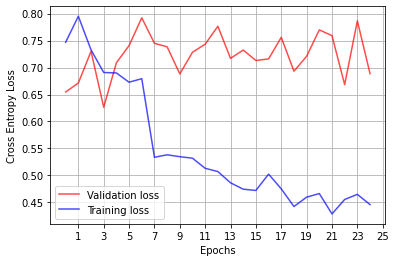

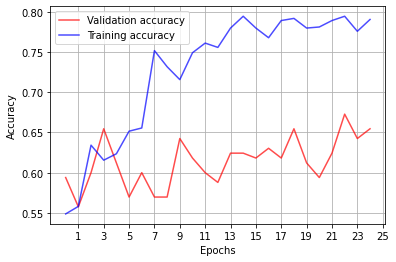

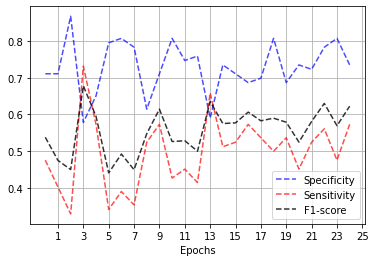

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
### Initialize data loader with reversed frangi
data_train = CardioDatasetFrangi(train_file, trsf, to_tensor = True, reverse=True) # set reverse to true
data_val = CardioDatasetFrangi(val_file, trsf, to_tensor = True, reverse=True) 
dataloader = []
dataloader = {'train': DataLoader(data_train,  mini_batch_size, shuffle=True, num_workers=0), 'val': DataLoader(data_val,  mini_batch_size, shuffle=True, num_workers=0)}
dataset_sizes = {'train': len(data_train), 'val': len(data_val)}

pretrained = True
model_reversed_frangi = initialize_model(modelName, num_classes, pretrained)

# Modify input channel from 3 to 4
model_reversed_frangi.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_reversed_frangi = model_reversed_frangi.to(device) 
criterion = nn.CrossEntropyLoss()

l_rate = 0.0025
w_decay_frangi = 0.1557 #5e-3
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_reversed_frangi.parameters(), lr=l_rate,weight_decay=w_decay_frangi, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_reversed_frangi, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val = train_model_Frg(model_reversed_frangi, dataloader, dataset_sizes, criterion, optimizer, exp_lr_scheduler,
                      num_epochs)

plot_performance(base_folder,model_names[3],num_epochs, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val, save=False)
#torch.save(model_reversed_frangi.state_dict(), base_folder+'Models/'+model_names[3]+'.pth')

## SimSiam

In [ ]:
# !git clone https://github.com/Omarraita/SimSiam.git

Cloning into 'SimSiam'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 318 (delta 181), reused 181 (delta 73), pack-reused 0
Receiving objects: 100% (318/318), 18.73 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [ ]:
cd /content/drive/My Drive/Robotics project I/SimSiam

/content/drive/My Drive/Robotics project I/SimSiam


In [ ]:
!pip install thop

In [ ]:
# For the Pretraining, set frangi to 1 to train with frangi positive examples

In [ ]:
#!python main.py --batch_size 124 --epochs 60 --feature_dim 2048 --base_folder '/content/drive/MyDrive/Robotics project I/' --frangi 0

In [ ]:
#!python main.py --batch_size 124 --epochs 60 --feature_dim 2048 --base_folder '/content/drive/MyDrive/Robotics project I/' --frangi 1

Using frangi ...
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
# Model Params: 18.52M FLOPs: 564.00M
Train Epoch: [1/60] Loss: -0.0222: 100% 7/7 [00:18<00:00,  2.69s/it]
Train Epoch: [2/60] Loss: -0.0834: 100% 7/7 [00:18<00:00,  2.70s/it]
Train Epoch: [3/60] Loss: -0.1375: 100% 7/7 [00:18<00:00,  2.68s/it]
Train Epoch: [4/60] Loss: -0.1947: 100% 7/7 [00:18<00:00,  2.67s/it]
Train Epoch: [5/60] Loss: -0.2537: 100% 7/7 [00:18<00:00,  2.68s/it]
Train Epoch: [6/60] Loss: -0.3112: 100% 7/7 [00:19<00:00,  2.75s/it]
Train Epoch: [7/60] Loss: -0.3480: 100% 7/7 [00:19<00:00,  2.75s/it]
Train

Epoch 0/24
----------
train Loss: 17.2450 Acc: 0.5073
val Loss: 12.5931 Acc: 0.4909
Sensitivity:  0.82  Specificity:  0.17  F1 score:  0.61

Epoch 1/24
----------
train Loss: 8.7732 Acc: 0.5314
val Loss: 17.7960 Acc: 0.5030
Sensitivity:  0.00  Specificity:  1.00  F1 score:  0.00

Epoch 2/24
----------
train Loss: 28.6195 Acc: 0.4993
val Loss: 17.6734 Acc: 0.5152
Sensitivity:  0.90  Specificity:  0.13  F1 score:  0.65

Epoch 3/24
----------
train Loss: 14.6239 Acc: 0.5220
val Loss: 4.6731 Acc: 0.5758
Sensitivity:  0.50  Specificity:  0.65  F1 score:  0.54

Epoch 4/24
----------
train Loss: 7.9110 Acc: 0.5514
val Loss: 6.8873 Acc: 0.5515
Sensitivity:  0.15  Specificity:  0.95  F1 score:  0.24

Epoch 5/24
----------
train Loss: 13.1794 Acc: 0.5300
val Loss: 11.1201 Acc: 0.5394
Sensitivity:  0.55  Specificity:  0.53  F1 score:  0.54

Epoch 6/24
----------
train Loss: 11.6002 Acc: 0.5220
val Loss: 19.0510 Acc: 0.5091
Sensitivity:  0.99  Specificity:  0.04  F1 score:  0.67

Epoch 7/24
------

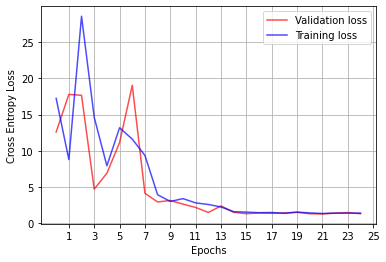

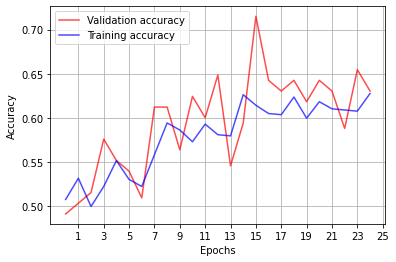

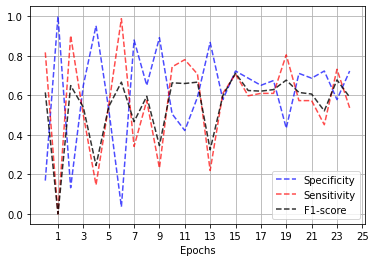

In [ ]:
from model import Model
from linear import Net

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

########################## model_simsiam #################################
# Transforms
from gaussian_blur import GaussianBlur
from torchvision.transforms import transforms
size = 96
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                  A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                  A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                  A.Resize(96, 96)
                  ]) 
### Initialize data loader
data_train = CardioDataset(train_file, trsf, to_tensor = True) # need to load data to get indices
data_val = CardioDataset(val_file, trsf, to_tensor = True) # need to load data to get indices
dataloader = []
dataloader = {'train': DataLoader(data_train,  mini_batch_size, shuffle=True, num_workers=0), 'val': DataLoader(data_val,  mini_batch_size, shuffle=True, num_workers=0)}
dataset_sizes = {'train': len(data_train), 'val': len(data_val)}

model = Net(num_class=2, pretrained_path=base_folder+'SimSiam/results/2048_200_124_50_model.pth').cuda()

criterion = nn.CrossEntropyLoss()

lr = 0.77
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_simsiam, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val = train_model_v3(model, dataloader,dataset_sizes, criterion, optimizer, exp_lr_scheduler,
                       num_epochs)

plot_performance(base_folder,model_names[4],num_epochs, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val, save=False)
#torch.save(model_simsiam.state_dict(), base_folder+'Models/'+model_names[4]+'.pth')

## Simsiam with frangi

Epoch 0/24
----------
train Loss: 14.4004 Acc: 0.5087
val Loss: 7.3049 Acc: 0.5636
Sensitivity:  0.63  Specificity:  0.49  F1 score:  0.59

Epoch 1/24
----------
train Loss: 13.9991 Acc: 0.5287
val Loss: 14.1227 Acc: 0.5758
Sensitivity:  0.35  Specificity:  0.80  F1 score:  0.45

Epoch 2/24
----------
train Loss: 20.3120 Acc: 0.5381
val Loss: 16.1545 Acc: 0.5455
Sensitivity:  0.11  Specificity:  0.98  F1 score:  0.19

Epoch 3/24
----------
train Loss: 15.0118 Acc: 0.5794
val Loss: 8.3453 Acc: 0.5636
Sensitivity:  0.85  Specificity:  0.28  F1 score:  0.66

Epoch 4/24
----------
train Loss: 10.5600 Acc: 0.5634
val Loss: 3.2763 Acc: 0.6667
Sensitivity:  0.74  Specificity:  0.59  F1 score:  0.69

Epoch 5/24
----------
train Loss: 17.6809 Acc: 0.5260
val Loss: 16.6798 Acc: 0.5879
Sensitivity:  0.96  Specificity:  0.22  F1 score:  0.70

Epoch 6/24
----------
train Loss: 11.6905 Acc: 0.5434
val Loss: 9.5107 Acc: 0.5576
Sensitivity:  0.32  Specificity:  0.80  F1 score:  0.42

Epoch 7/24
------

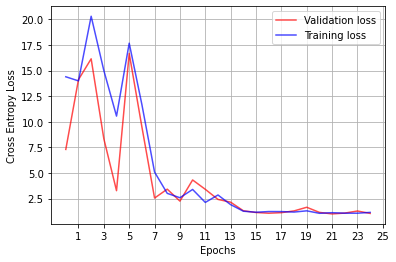

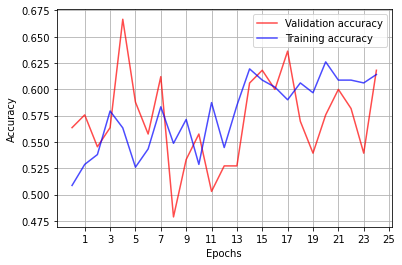

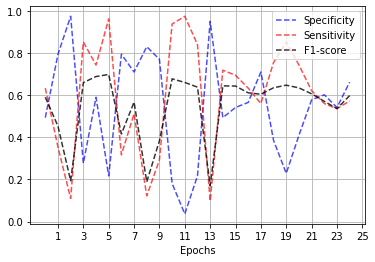

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

########################## model_simsiam_frangi #################################
model = Net(num_class=2, pretrained_path=base_folder+'SimSiam/results/2048_200_124_50_frangi_model.pth').cuda()
criterion = nn.CrossEntropyLoss()

lr = 0.77
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_simsiam_frangi, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val = train_model_v3(model, dataloader,dataset_sizes, criterion, optimizer, exp_lr_scheduler,
                       num_epochs)

plot_performance(base_folder,model_names[5],num_epochs, ft_hist, ft_hist_train, ft_specificity, ft_sensitivity, ft_f1_score, loss_train, loss_val, save=False)
#torch.save(model_simsiam_frangi.state_dict(), base_folder+'Models/'+model_names[5]+'.pth')

## Test the model on the test set

In [ ]:
model_names

{0: 'model_scratch',
 1: 'model_pretrained',
 2: 'model_frangi',
 3: 'model_frangi_reversed',
 4: 'model_simsiam',
 5: 'model_simsiam_frangi',
 6: 'model_art_data'}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_regular = initialize_model('resnet18', num_classes=2, pretrained_model=True).to(device)
model_regular.load_state_dict(torch.load(base_folder+'Models/'+model_names[1]+'.pth'))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



True


<All keys matched successfully>

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_art_data= initialize_model('resnet18', num_classes=2, pretrained_model=True).to(device)
model_art_data.load_state_dict(torch.load(base_folder+'Models/'+model_names[6]+'.pth'))

True


<All keys matched successfully>

In [ ]:
model_frangi = initialize_model('resnet18', num_classes=2, pretrained_model=True)
model_frangi.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_frangi = model_frangi.to(device)
model_frangi.load_state_dict(torch.load(base_folder+'Models/'+model_names[2]+'.pth'))

True


<All keys matched successfully>

In [ ]:
model_reversed_frangi = initialize_model('resnet18', num_classes=2, pretrained_model=True)
model_reversed_frangi.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_reversed_frangi = model_reversed_frangi.to(device)
model_reversed_frangi.load_state_dict(torch.load(base_folder+'Models/'+model_names[3]+'.pth'))

True


<All keys matched successfully>

In [ ]:
from SimSiam.model import Model
from SimSiam.linear import Net
model_simsiam = Net(num_class=2, pretrained_path=base_folder+'Models/'+model_names[4]+'.pth').to(device)

In [ ]:
from SimSiam.model import Model
from SimSiam.linear import Net
model_simsiam_frangi = Net(num_class=2, pretrained_path=base_folder+'Models/'+model_names[5]+'.pth').to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


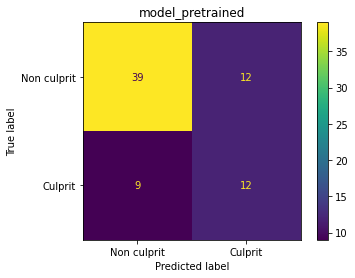

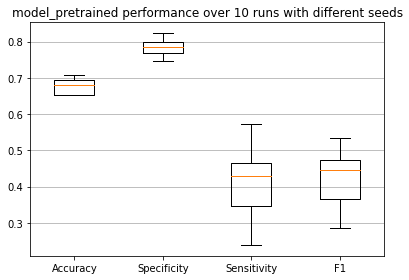

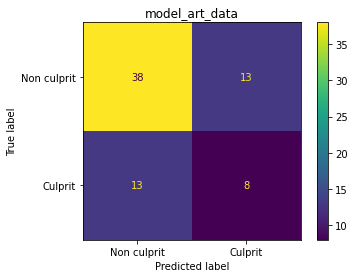

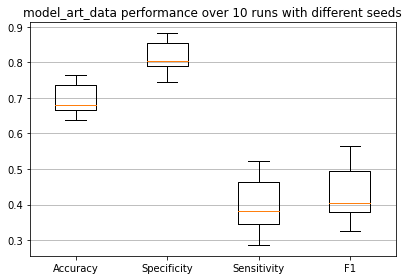

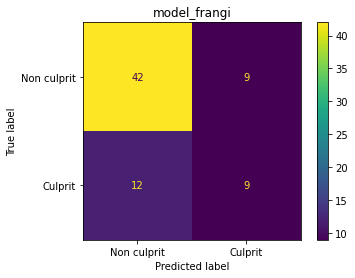

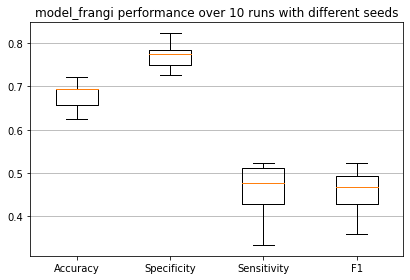

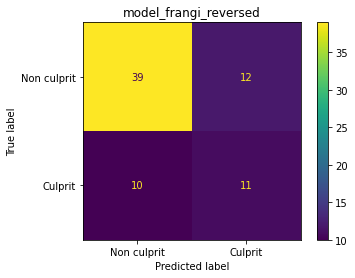

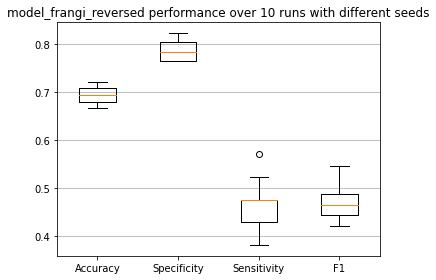

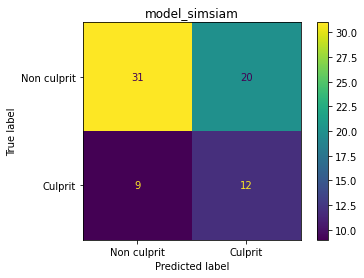

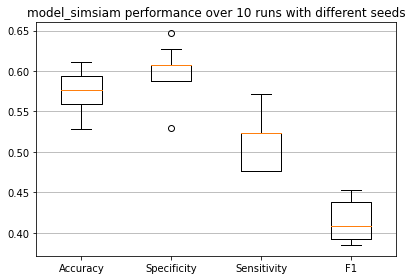

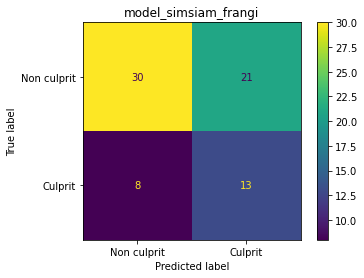

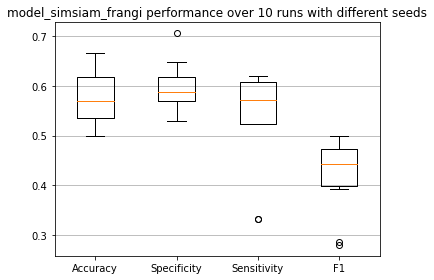

In [ ]:
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                A.Resize(224, 224)
                ]) 
test_file = base_folder + 'Datasets/test_patches.npz'
model_names = {0:'model_scratch', 1:'model_pretrained', 2:'model_frangi', 3:'model_frangi_reversed', 4:'model_simsiam', 5:'model_simsiam_frangi', 6:'model_art_data'}

# Test regular model
test_model_ten_runs(test_file, base_folder, trsf, model_regular, model_names[1], frangi=False, save=False)
# Test model trained on artificial data
test_model_ten_runs(test_file, base_folder, trsf, model_art_data, model_names[6], frangi=False, save=False)

# Test 4-channels frangi model
test_model_ten_runs(test_file, base_folder, trsf, model_frangi, model_names[2], frangi=True,reversed=False, save=False)
# Test 4-channels reversed frangi model
test_model_ten_runs(test_file, base_folder, trsf, model_reversed_frangi, model_names[3], frangi=True,reversed=True, save=False)

# For siamese nets, apply the same transformations that were applied in pre-training/tuning phase
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                A.Resize(96, 96)
                ]) 
# Test model pretrained with siamese net
test_model_ten_runs(test_file, base_folder, trsf, model_simsiam, model_names[4], frangi=False, save=False)
# Test siamese net pretrained with frangi positive examples
test_model_ten_runs(test_file, base_folder, trsf, model_simsiam_frangi, model_names[5], frangi=False, save=False)

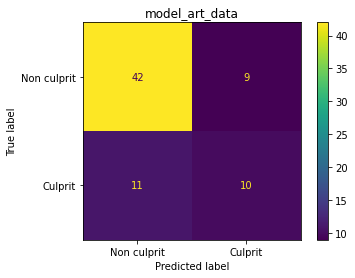

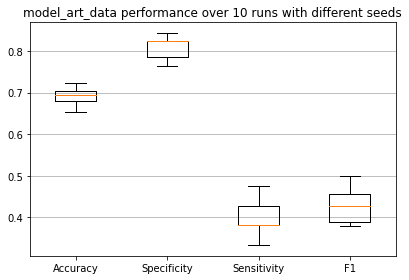

In [ ]:
# Test artificial data model
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                A.Resize(224, 224)
                ]) 
test_model_ten_runs(test_file, base_folder, trsf, model_art_data, model_names[6], frangi=False, save=False)

## Compare predictions

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

test_file = base_folder + 'Datasets/test_patches.npz'
visualization_file = test_file

trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=1),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=1),
                A.Resize(224, 224)
                ])

# Regular
train_data = CardioDataset(visualization_file, trsf, to_tensor = True)
_, _, _, _, _, _, _, y_true, all_outputs = test_model_conf_mat(model_regular, train_data, 10, Frg=False)
misclassified_regular = np.where(all_outputs.numpy()!=y_true.numpy())
well_classified_regular = np.where(all_outputs.numpy()==y_true.numpy())

# Frangi
train_data_frangi = CardioDatasetFrangi(visualization_file, trsf, to_tensor = True, reverse=False)
#train_data_reversed_frangi = CardioDatasetFrangi(visualization_file, trsf, to_tensor = True, reverse=True)
_, _, _, _, _, _, _, y_true_frangi, outputs_frangi = test_model_conf_mat(model_frangi, train_data_frangi, 10, Frg=True)
misclassified_frangi = np.where(outputs_frangi.numpy()!=y_true_frangi.numpy())
well_classified_frangi = np.where(outputs_frangi.numpy()!=y_true_frangi.numpy())

# Simsiam
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                A.Resize(96, 96)
                ]) 
train_data_simsiam = CardioDataset(visualization_file, trsf, to_tensor = True)

_, _, _, _, _, _, _, y_true_simsiam, outputs_simsiam = test_model_conf_mat(model_simsiam, train_data_simsiam, 10, Frg=False)
misclassified_simsiam = np.where(outputs_simsiam.numpy()!=y_true_simsiam.numpy())
well_classified_simsiam = np.where(outputs_simsiam.numpy()==y_true_simsiam.numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
misclassified = np.intersect1d(misclassified_regular, misclassified_frangi,misclassified_simsiam)
well_classified = np.intersect1d(well_classified_regular, well_classified_frangi,well_classified_simsiam)

In [ ]:
misclassified

array([ 1,  2,  9, 15, 16, 29, 38, 41, 46, 47, 48, 49, 60, 71])

In [ ]:
well_classified

array([11, 21, 25, 32, 39, 45, 51, 64])

In [ ]:
well_classified

array([11, 21, 25, 32, 39, 45, 51, 64])

In [ ]:
f = np.load(visualization_file, allow_pickle = True)
X, _, filenames, annotated_patches = f['X'], f['Y'], f['filenames'], f['annotated_patches']

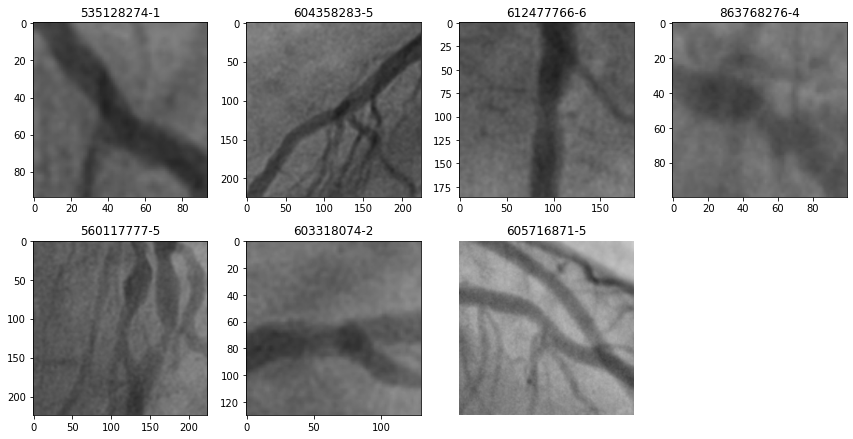

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Display patches that were correctly classified by all the models
data_to_display = well_classified

columns = 4
rows = int(len(data_to_display)/columns)+1
fig=plt.figure(figsize=(columns*3, rows*3))
for i, j in enumerate(data_to_display):
    img = X[j]
    if(i>0):
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
      plt.title(filenames[j][:-4])
plt.tight_layout()
plt.axis('off')
plt.show()

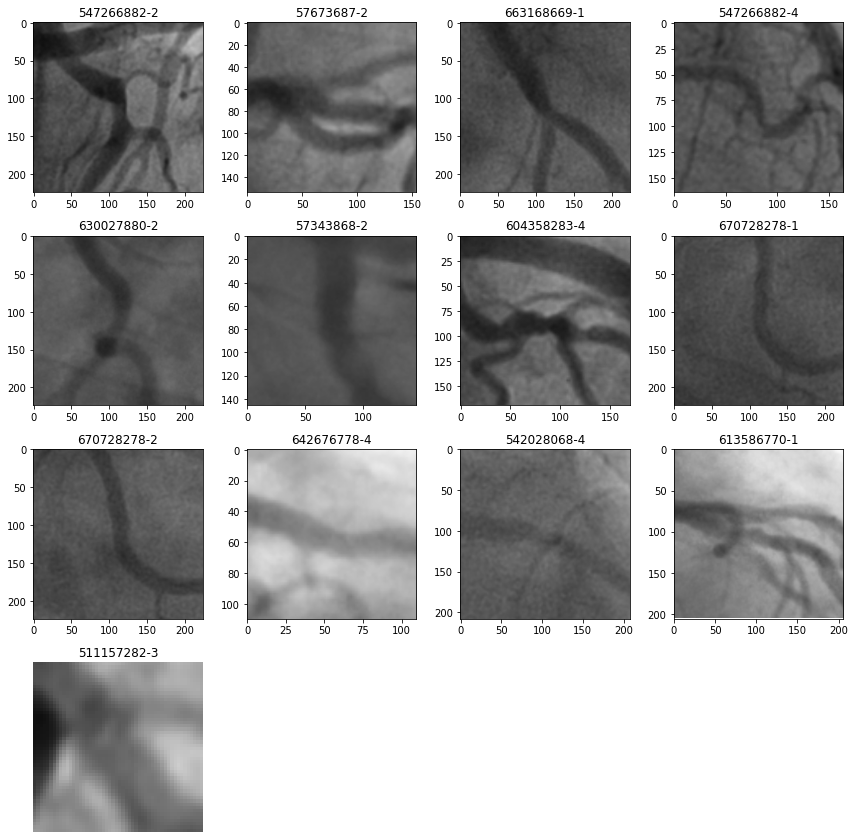

In [ ]:
# Display patches that were misclassified by all the models

data_to_display = misclassified

columns = 4
rows = int(len(data_to_display)/columns)+1
fig=plt.figure(figsize=(columns*3, rows*3))
for i, j in enumerate(data_to_display):
    img = X[j]
    if(i>0):
      fig.add_subplot(rows, columns, i)
      plt.imshow(img)
      plt.title(filenames[j][:-4])
plt.tight_layout()
plt.axis('off')
plt.show()

## Gradcam

In [ ]:
model_names

{0: 'model_scratch',
 1: 'model_pretrained',
 2: 'model_frangi',
 3: 'model_frangi_reversed',
 4: 'model_simsiam',
 5: 'model_simsiam_frangi',
 6: 'model_art_data'}

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=1),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=1),
                A.Resize(224, 224)
                ]) 

random_index = 0 # 0, 5, 80 || 45 || 14, 40
visualization_file = base_folder + 'Datasets/test_patches.npz'

test_data_frangi = CardioDatasetFrangi(visualization_file, trsf, to_tensor = True, reverse=False)
test_data_reversed_frangi = CardioDatasetFrangi(visualization_file, trsf, to_tensor = True, reverse=True)
test_data_regular = CardioDataset(visualization_file, trsf, to_tensor = True)

trsf = A.Compose([A.MedianBlur(blur_limit=5, p=1),  
                A.Rotate (limit=45, interpolation=1, border_mode=4, p=0.9),
                A.ShiftScaleRotate (shift_limit=0.1, scale_limit=0, rotate_limit=0, interpolation=1, border_mode=4, p=0.9),
                A.Resize(96, 96)
                ]) 
test_data_simsiam = CardioDataset(visualization_file, trsf, to_tensor = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


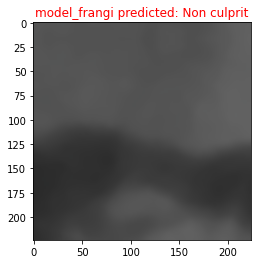

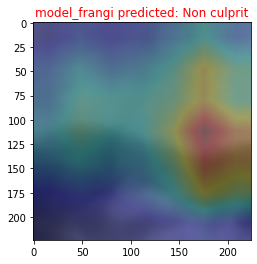

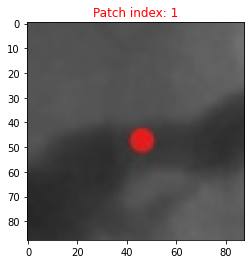

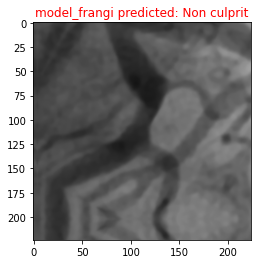

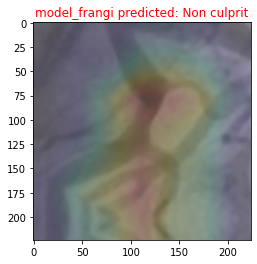

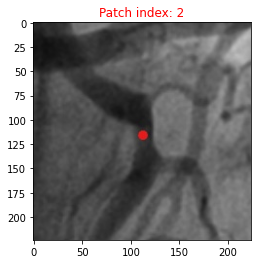

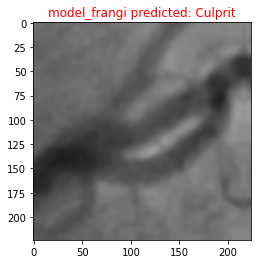

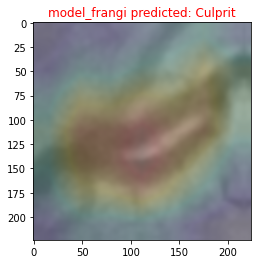

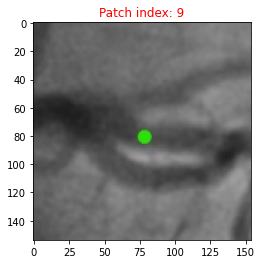

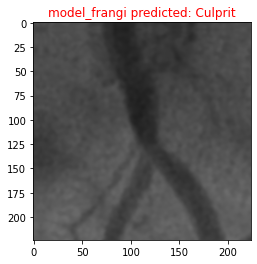

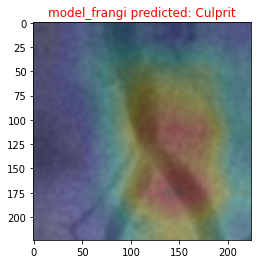

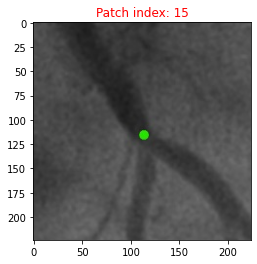

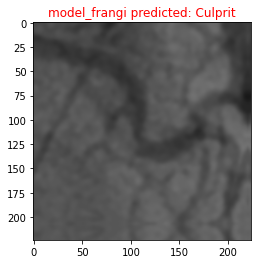

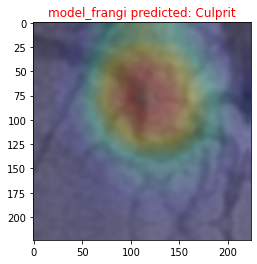

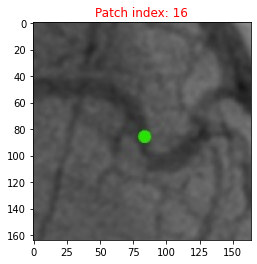

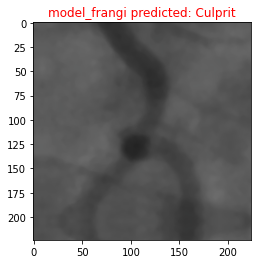

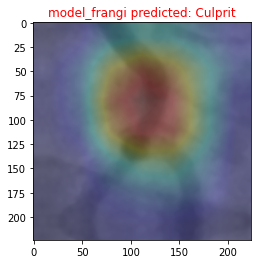

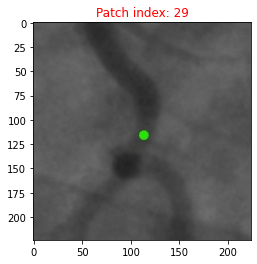

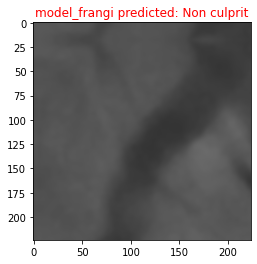

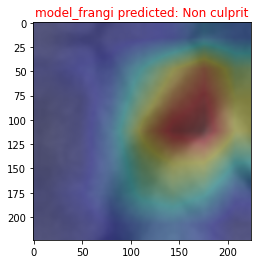

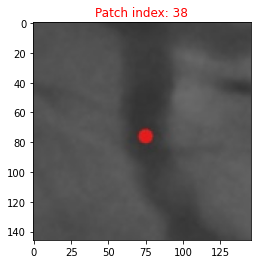

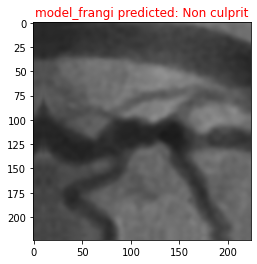

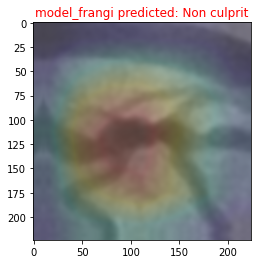

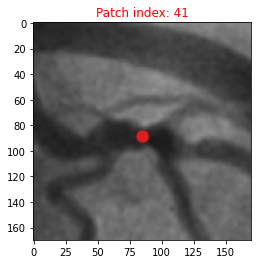

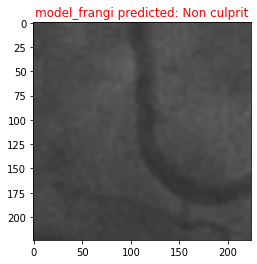

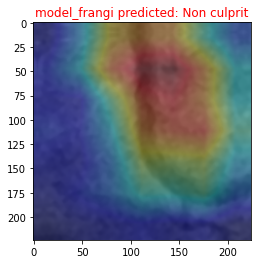

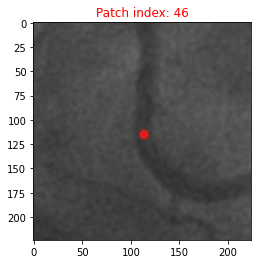

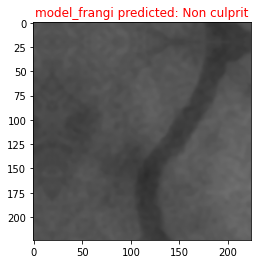

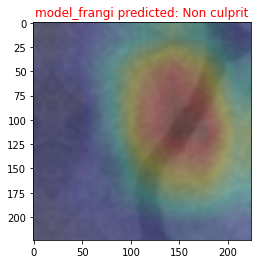

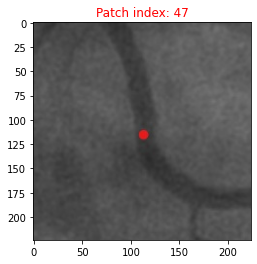

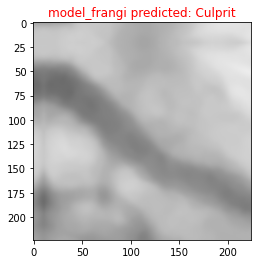

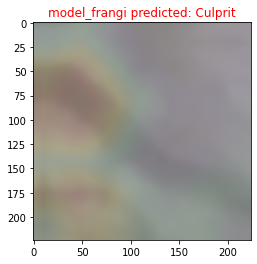

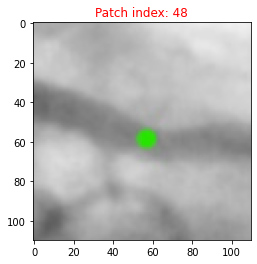

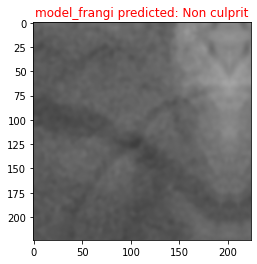

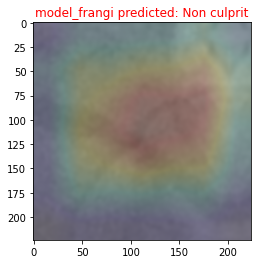

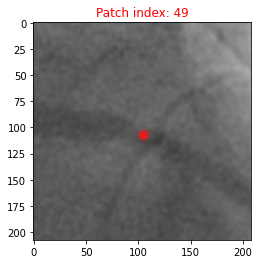

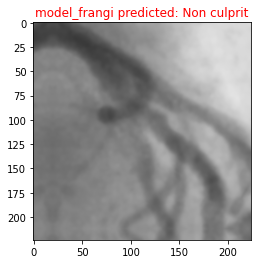

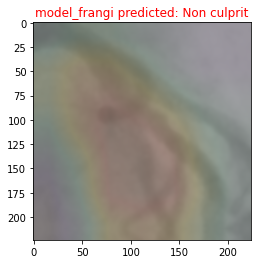

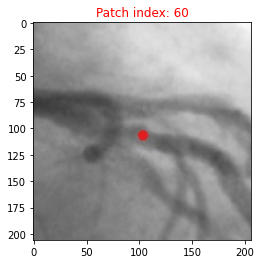

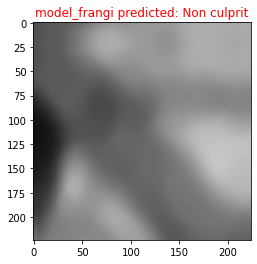

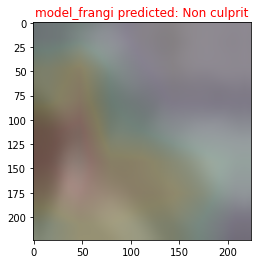

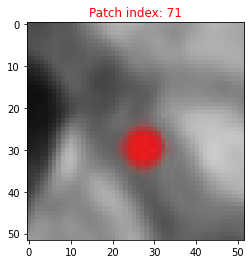

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
########### Gradcam for frangi #############
use_frangi = True
_, _, _, _, _, _, _, y_true_frangi, outputs_frangi = test_model_conf_mat(model_frangi, test_data_frangi, 10, use_frangi)

# Compute gradcam for all misclassified patches
for patch_index in [ 1,  2,  9, 15, 16, 29, 38, 41, 46, 47, 48, 49, 60, 71]:
  display_gradcam(model_frangi, model_names[2], base_folder, visualization_file, test_data_frangi,y_true_frangi, outputs_frangi, patch_index, use_frangi)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


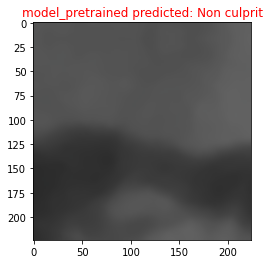

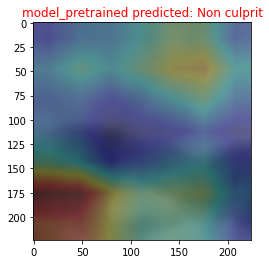

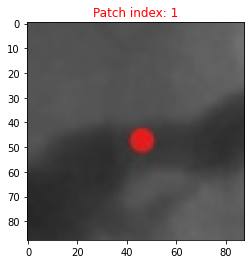

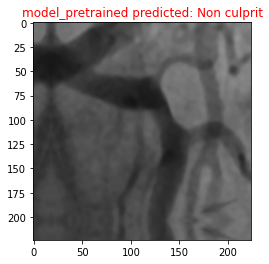

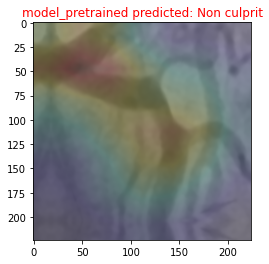

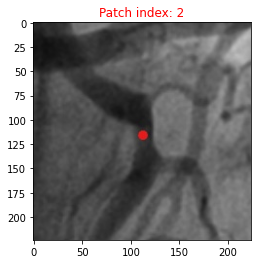

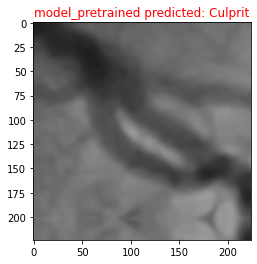

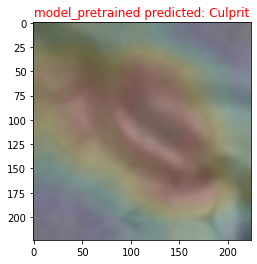

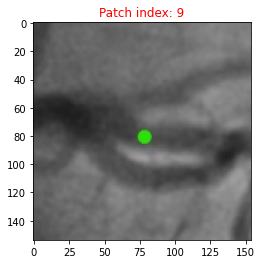

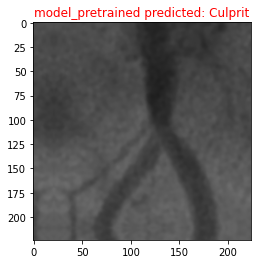

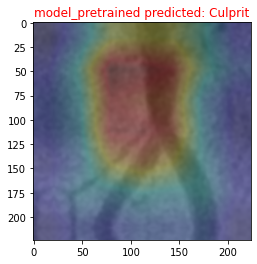

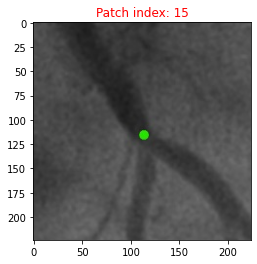

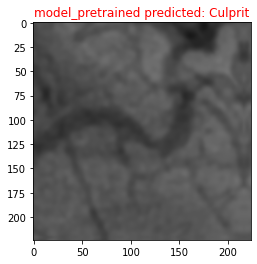

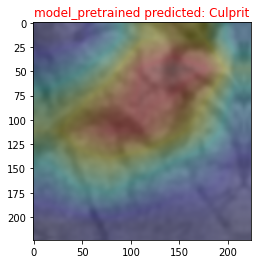

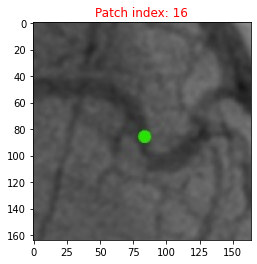

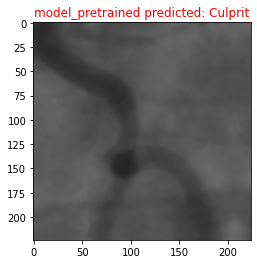

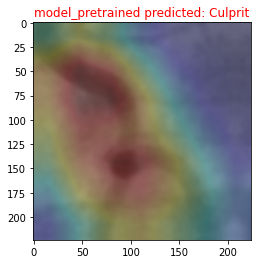

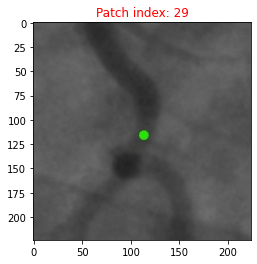

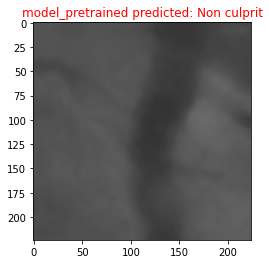

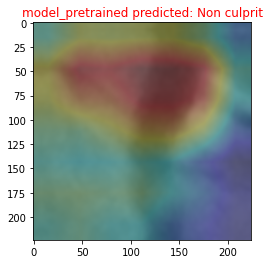

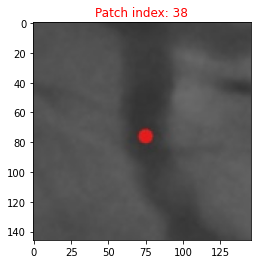

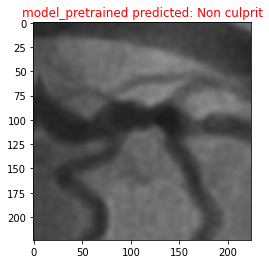

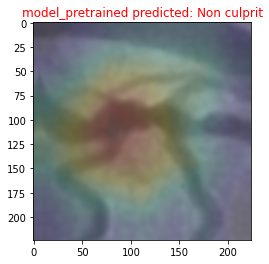

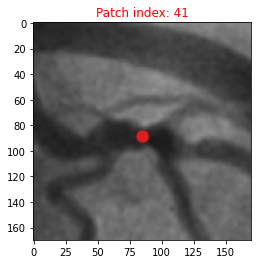

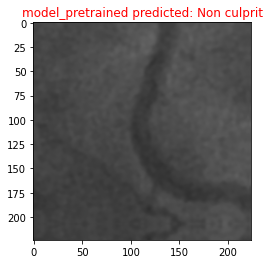

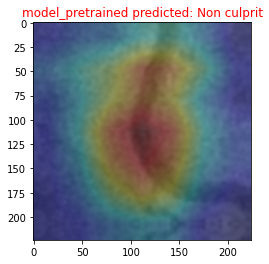

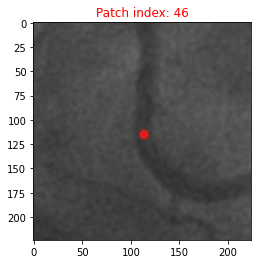

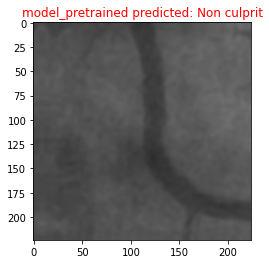

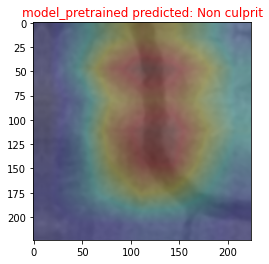

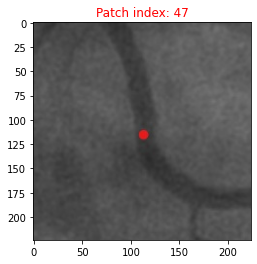

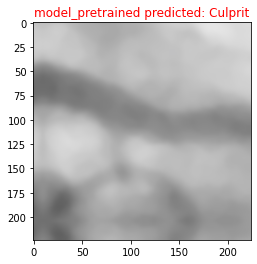

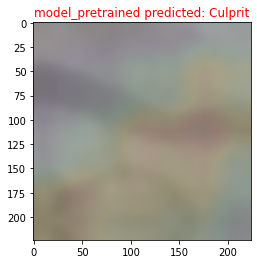

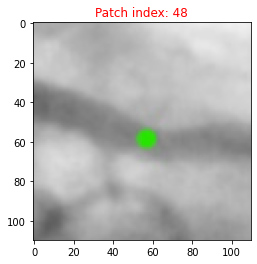

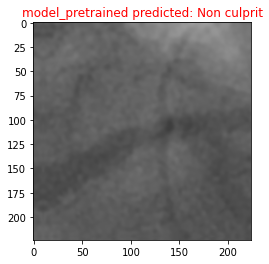

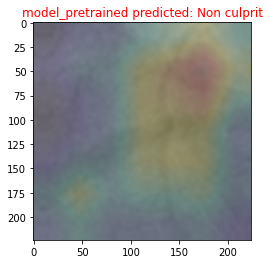

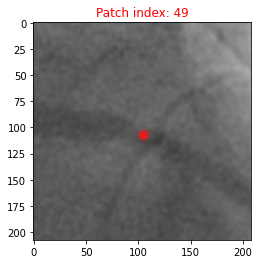

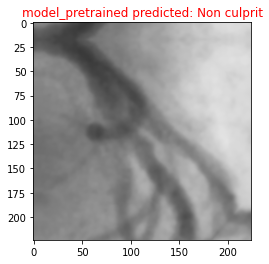

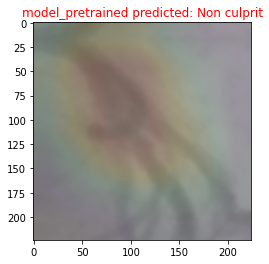

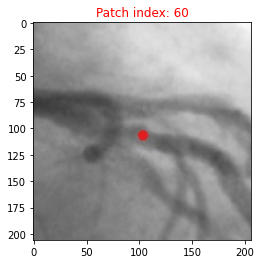

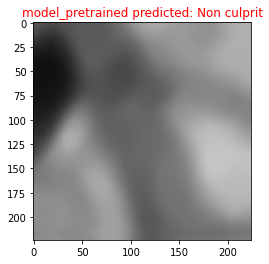

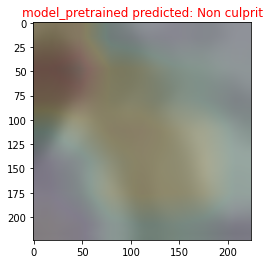

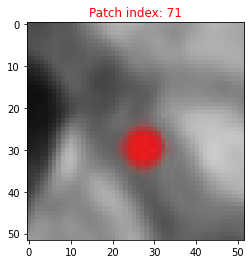

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
########## Gradcam for other models #############
use_frangi = False

# Test the predictions 
_, _, _, _, _, _, _, y_true, all_outputs = test_model_conf_mat(model_regular, test_data_regular, 10, use_frangi)
for patch_index in [ 1,  2,  9, 15, 16, 29, 38, 41, 46, 47, 48, 49, 60, 71]:
  display_gradcam(model_regular, model_names[1], base_folder, visualization_file, test_data_regular,y_true, all_outputs, patch_index, use_frangi)

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
########### Gradcam for reversed frangi #############
use_frangi = True
_, _, _, _, _, _, _, y_true_frangi_rev, outputs_frangi_rev = test_model_conf_mat(model_reversed_frangi, test_data_reversed_frangi, 10, use_frangi)
# Compute gradcam for all misclassified patches
for patch_index in [ 1,  2,  9, 15, 16, 29, 38, 41, 46, 47, 48, 49, 60, 71]:
  display_gradcam(model_reversed_frangi, model_names[3], base_folder, visualization_file, test_data_reversed_frangi, y_true_frangi_rev, outputs_frangi_rev, patch_index, use_frangi)

## Features visualization (used in SimCLR debugging)

In [ ]:
#model = models.resnet152(pretrained=True)
model1 = model_ft
model1.fc = nn.Sequential(
    nn.Dropout(0.5),
    #nn.Linear(num_ftrs, 10)
)
print(model)

(1518,)
(1518, 512)


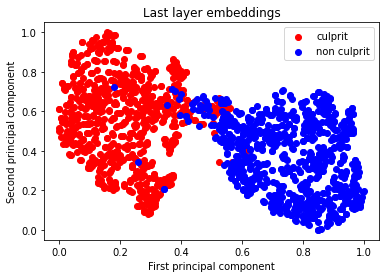

In [ ]:
i=0

labels_ = []
outputs = []
for batch in dataloader['train']:
  model1.eval()
  if i==0:
    labels = batch['label'].detach().numpy()[:,0]
    images = batch['image'].to(device)
    output = model1(images)
    current_outputs = output.detach().cpu().numpy()
    #features = np.concatenate((outputs, current_outputs))
  i+=1
  if i>0:
    labels = np.concatenate((labels, batch['label'].detach().numpy()[:,0]))
    images = batch['image'].to(device)
    output = model1(images)
    current_outputs = np.concatenate((current_outputs, output.detach().cpu().numpy()))

print(np.shape(labels))
print(np.shape(current_outputs))

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(current_outputs)

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)


import matplotlib.pyplot as plt

culprit = np.where(labels == 1)
non_culprit = np.where(labels ==0)
tx_culprit = tx[culprit]
ty_culprit = ty[culprit]
tx_non_culprit = tx[non_culprit]
ty_non_culprit = ty[non_culprit]

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(tx_culprit, ty_culprit, color='r', label ='culprit')
ax.scatter(tx_non_culprit, ty_non_culprit, color='b', label ='non culprit')

ax.legend(loc='best')
ax.set_title('Last layer embeddings')
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
# finally, show the plot
plt.show()